<a href="https://colab.research.google.com/github/debasishsarangi88/S6/blob/master/EVA5_Seession6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EVA 5 - Session 6

## 1. With L1 + BN: 

## 2. With L2 + BN: 

## 3. With L1 and L2 with BN: 

## 4. With GBN: 

## 5. With L1 and L2 with GBN: 

3. Results: 
    1. Parameters: 9,608
    2. Best Training Accuracy: 99.25%
    3. Best Test Accuracy: 99.48%

# Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
g_dataloader_args = dict(shuffle=True, batch_size=256, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=256)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
g_train_loader = torch.utils.data.DataLoader(train, **g_dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)
g_test_loader = torch.utils.data.DataLoader(test, **g_dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

# The model
Let's start with the model we first saw

In [ ]:
import torch.nn.functional as F
dropout_value = 0.01
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) 

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) 

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        )

        self.pool1 = nn.MaxPool2d(2, 2) 

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) 

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) 
        
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) 

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) 

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) 

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        ) 

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) 

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.gap(x)
        x = self.convblock9(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
              ReLU-6            [-1, 8, 24, 24]               0
       BatchNorm2d-7            [-1, 8, 24, 24]              16
           Dropout-8            [-1, 8, 24, 24]               0
            Conv2d-9           [-1, 16, 22, 22]           1,152
             ReLU-10           [-1, 16, 22, 22]               0
      BatchNorm2d-11           [-1, 16, 22, 22]              32
          Dropout-12           [-1, 16, 22, 22]               0
        MaxPool2d-13           [-1, 16, 11, 11]               0
           Conv2d-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch, iter):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)

    # Calculating L1 Loss.
    if(iter == 1 or iter == 3 or iter == 5):
      lambda_l1 = 0.001
      l1 = 0
      for p in model.parameters():
        l1 = l1 + p.abs().sum()
      loss = loss + lambda_l1 * l1
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [ ]:
from torch.optim.lr_scheduler import StepLR

models = {}

for iter in range(1, 6): 
  # L2 Loss
  if(iter == 2 or iter == 3 or iter == 5):
    wd_val = 0.01
  else:
    wd_val = 0

  if(iter == 4 or iter == 5):
    learn_r = 1e-2
    wd_val = 5e-4

  model =  Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=wd_val)
  scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
  models[iter] = model
  #history = models[iter]

  EPOCHS = 25
  if(iter == 1):
    print("\n\nL1 + BN", end="\n\n")
  elif(iter == 2):
    print("L2 + BN", end="\n\n")
  elif(iter == 3):
    print("L1 and L2 with BN", end="\n\n")
  elif(iter == 4):
    print("GBN", end="\n\n")
  else:
    print("L1 and L2 with GBN", end="\n\n")
  for epoch in range(EPOCHS):
      print("EPOCH:", epoch)
      if(iter == 4 or iter == 5):
        train(model, device, g_train_loader, optimizer, epoch, iter)
        test(model, device, g_test_loader)
      else:
        train(model, device, train_loader, optimizer, epoch, iter)
        test(model, device, test_loader)
    

  0%|          | 0/938 [00:00<?, ?it/s]



L1 + BN

EPOCH: 0


Loss=0.4742060601711273 Batch_id=937 Accuracy=92.25: 100%|██████████| 938/938 [00:33<00:00, 27.67it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0869, Accuracy: 9737/10000 (97.37%)

EPOCH: 1


Loss=0.3854403793811798 Batch_id=937 Accuracy=96.90: 100%|██████████| 938/938 [00:33<00:00, 27.79it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0768, Accuracy: 9778/10000 (97.78%)

EPOCH: 2


Loss=0.6417585611343384 Batch_id=937 Accuracy=97.12: 100%|██████████| 938/938 [00:33<00:00, 27.66it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0812, Accuracy: 9757/10000 (97.57%)

EPOCH: 3


Loss=0.3371962606906891 Batch_id=937 Accuracy=97.17: 100%|██████████| 938/938 [00:34<00:00, 27.55it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0662, Accuracy: 9802/10000 (98.02%)

EPOCH: 4


Loss=0.5388401746749878 Batch_id=937 Accuracy=97.22: 100%|██████████| 938/938 [00:34<00:00, 27.54it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1147, Accuracy: 9646/10000 (96.46%)

EPOCH: 5


Loss=0.3508449196815491 Batch_id=937 Accuracy=97.26: 100%|██████████| 938/938 [00:34<00:00, 27.47it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0816, Accuracy: 9748/10000 (97.48%)

EPOCH: 6


Loss=0.26677221059799194 Batch_id=937 Accuracy=97.31: 100%|██████████| 938/938 [00:34<00:00, 27.51it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0719, Accuracy: 9768/10000 (97.68%)

EPOCH: 7


Loss=0.4285707473754883 Batch_id=937 Accuracy=97.26: 100%|██████████| 938/938 [00:34<00:00, 27.40it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0681, Accuracy: 9794/10000 (97.94%)

EPOCH: 8


Loss=0.2762078642845154 Batch_id=937 Accuracy=97.34: 100%|██████████| 938/938 [00:33<00:00, 27.64it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0770, Accuracy: 9758/10000 (97.58%)

EPOCH: 9


Loss=0.2653609812259674 Batch_id=937 Accuracy=97.28: 100%|██████████| 938/938 [00:34<00:00, 27.46it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0551, Accuracy: 9838/10000 (98.38%)

EPOCH: 10


Loss=0.377265989780426 Batch_id=937 Accuracy=97.10: 100%|██████████| 938/938 [00:34<00:00, 27.50it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1039, Accuracy: 9663/10000 (96.63%)

EPOCH: 11


Loss=0.39005982875823975 Batch_id=937 Accuracy=97.23: 100%|██████████| 938/938 [00:34<00:00, 27.42it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0616, Accuracy: 9792/10000 (97.92%)

EPOCH: 12


Loss=0.34564387798309326 Batch_id=937 Accuracy=97.27: 100%|██████████| 938/938 [00:34<00:00, 27.42it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0541, Accuracy: 9833/10000 (98.33%)

EPOCH: 13


Loss=0.4300181269645691 Batch_id=937 Accuracy=97.23: 100%|██████████| 938/938 [00:34<00:00, 27.54it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0577, Accuracy: 9814/10000 (98.14%)

EPOCH: 14


Loss=0.6038367748260498 Batch_id=937 Accuracy=97.34: 100%|██████████| 938/938 [00:34<00:00, 27.48it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1110, Accuracy: 9626/10000 (96.26%)

EPOCH: 15


Loss=0.2820071280002594 Batch_id=937 Accuracy=97.31: 100%|██████████| 938/938 [00:34<00:00, 27.41it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0586, Accuracy: 9818/10000 (98.18%)

EPOCH: 16


Loss=0.24506598711013794 Batch_id=937 Accuracy=97.22: 100%|██████████| 938/938 [00:34<00:00, 27.51it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0640, Accuracy: 9792/10000 (97.92%)

EPOCH: 17


Loss=0.3472564220428467 Batch_id=937 Accuracy=97.36: 100%|██████████| 938/938 [00:34<00:00, 27.40it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0583, Accuracy: 9823/10000 (98.23%)

EPOCH: 18


Loss=0.2573622465133667 Batch_id=937 Accuracy=97.35: 100%|██████████| 938/938 [00:34<00:00, 27.39it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0877, Accuracy: 9740/10000 (97.40%)

EPOCH: 19


Loss=0.44382205605506897 Batch_id=937 Accuracy=97.36: 100%|██████████| 938/938 [00:34<00:00, 27.23it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0934, Accuracy: 9699/10000 (96.99%)

EPOCH: 20


Loss=0.26170656085014343 Batch_id=937 Accuracy=97.30: 100%|██████████| 938/938 [00:34<00:00, 27.19it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0582, Accuracy: 9808/10000 (98.08%)

EPOCH: 21


Loss=0.2388032227754593 Batch_id=937 Accuracy=97.39: 100%|██████████| 938/938 [00:34<00:00, 27.38it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0873, Accuracy: 9726/10000 (97.26%)

EPOCH: 22


Loss=0.3709006905555725 Batch_id=937 Accuracy=97.20: 100%|██████████| 938/938 [00:34<00:00, 27.31it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0714, Accuracy: 9782/10000 (97.82%)

EPOCH: 23


Loss=0.2954741418361664 Batch_id=937 Accuracy=97.21: 100%|██████████| 938/938 [00:34<00:00, 27.22it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0593, Accuracy: 9813/10000 (98.13%)

EPOCH: 24


Loss=0.2849721312522888 Batch_id=937 Accuracy=97.37: 100%|██████████| 938/938 [00:34<00:00, 27.08it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0639, Accuracy: 9795/10000 (97.95%)

L2 + BN

EPOCH: 0


Loss=0.07404367625713348 Batch_id=937 Accuracy=93.17: 100%|██████████| 938/938 [00:30<00:00, 30.33it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1092, Accuracy: 9796/10000 (97.96%)

EPOCH: 1


Loss=0.15456527471542358 Batch_id=937 Accuracy=97.51: 100%|██████████| 938/938 [00:30<00:00, 30.49it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0955, Accuracy: 9811/10000 (98.11%)

EPOCH: 2


Loss=0.13904425501823425 Batch_id=937 Accuracy=97.62: 100%|██████████| 938/938 [00:30<00:00, 30.44it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1077, Accuracy: 9781/10000 (97.81%)

EPOCH: 3


Loss=0.07117638736963272 Batch_id=937 Accuracy=97.66: 100%|██████████| 938/938 [00:30<00:00, 30.72it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0872, Accuracy: 9855/10000 (98.55%)

EPOCH: 4


Loss=0.12600751221179962 Batch_id=937 Accuracy=97.66: 100%|██████████| 938/938 [00:31<00:00, 30.25it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0992, Accuracy: 9787/10000 (97.87%)

EPOCH: 5


Loss=0.09466835111379623 Batch_id=937 Accuracy=97.64: 100%|██████████| 938/938 [00:31<00:00, 30.25it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0942, Accuracy: 9836/10000 (98.36%)

EPOCH: 6


Loss=0.20490284264087677 Batch_id=937 Accuracy=97.74: 100%|██████████| 938/938 [00:30<00:00, 30.42it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1282, Accuracy: 9719/10000 (97.19%)

EPOCH: 7


Loss=0.05276486277580261 Batch_id=937 Accuracy=97.71: 100%|██████████| 938/938 [00:30<00:00, 30.32it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1159, Accuracy: 9755/10000 (97.55%)

EPOCH: 8


Loss=0.255180686712265 Batch_id=937 Accuracy=97.80: 100%|██████████| 938/938 [00:30<00:00, 30.40it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1408, Accuracy: 9700/10000 (97.00%)

EPOCH: 9


Loss=0.170736163854599 Batch_id=937 Accuracy=97.81: 100%|██████████| 938/938 [00:30<00:00, 30.67it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1052, Accuracy: 9782/10000 (97.82%)

EPOCH: 10


Loss=0.09320314228534698 Batch_id=937 Accuracy=97.75: 100%|██████████| 938/938 [00:30<00:00, 30.63it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0829, Accuracy: 9838/10000 (98.38%)

EPOCH: 11


Loss=0.09619975090026855 Batch_id=937 Accuracy=97.83: 100%|██████████| 938/938 [00:30<00:00, 30.62it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0947, Accuracy: 9808/10000 (98.08%)

EPOCH: 12


Loss=0.10338591039180756 Batch_id=937 Accuracy=97.76: 100%|██████████| 938/938 [00:30<00:00, 30.33it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0832, Accuracy: 9844/10000 (98.44%)

EPOCH: 13


Loss=0.3206353783607483 Batch_id=937 Accuracy=97.82: 100%|██████████| 938/938 [00:31<00:00, 30.19it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1107, Accuracy: 9775/10000 (97.75%)

EPOCH: 14


Loss=0.08963805437088013 Batch_id=937 Accuracy=97.84: 100%|██████████| 938/938 [00:30<00:00, 30.36it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1244, Accuracy: 9709/10000 (97.09%)

EPOCH: 15


Loss=0.11022838205099106 Batch_id=937 Accuracy=97.81: 100%|██████████| 938/938 [00:30<00:00, 30.64it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1087, Accuracy: 9794/10000 (97.94%)

EPOCH: 16


Loss=0.13241538405418396 Batch_id=937 Accuracy=97.92: 100%|██████████| 938/938 [00:30<00:00, 30.73it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1507, Accuracy: 9646/10000 (96.46%)

EPOCH: 17


Loss=0.24688781797885895 Batch_id=937 Accuracy=97.80: 100%|██████████| 938/938 [00:30<00:00, 31.07it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1382, Accuracy: 9686/10000 (96.86%)

EPOCH: 18


Loss=0.08943835645914078 Batch_id=937 Accuracy=97.80: 100%|██████████| 938/938 [00:30<00:00, 30.40it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0941, Accuracy: 9834/10000 (98.34%)

EPOCH: 19


Loss=0.16623304784297943 Batch_id=937 Accuracy=97.79: 100%|██████████| 938/938 [00:30<00:00, 30.62it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0778, Accuracy: 9866/10000 (98.66%)

EPOCH: 20


Loss=0.16543789207935333 Batch_id=937 Accuracy=97.81: 100%|██████████| 938/938 [00:30<00:00, 30.71it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0828, Accuracy: 9817/10000 (98.17%)

EPOCH: 21


Loss=0.060040365904569626 Batch_id=937 Accuracy=97.83: 100%|██████████| 938/938 [00:30<00:00, 30.69it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0776, Accuracy: 9857/10000 (98.57%)

EPOCH: 22


Loss=0.28035879135131836 Batch_id=937 Accuracy=97.96: 100%|██████████| 938/938 [00:30<00:00, 30.61it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0903, Accuracy: 9826/10000 (98.26%)

EPOCH: 23


Loss=0.1660863608121872 Batch_id=937 Accuracy=97.84: 100%|██████████| 938/938 [00:30<00:00, 31.05it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0801, Accuracy: 9847/10000 (98.47%)

EPOCH: 24


Loss=0.18366341292858124 Batch_id=937 Accuracy=97.86: 100%|██████████| 938/938 [00:30<00:00, 30.86it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1018, Accuracy: 9789/10000 (97.89%)

L1 and L2 with BN

EPOCH: 0


Loss=0.342562198638916 Batch_id=937 Accuracy=91.49: 100%|██████████| 938/938 [00:34<00:00, 26.86it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1313, Accuracy: 9747/10000 (97.47%)

EPOCH: 1


Loss=0.43412768840789795 Batch_id=937 Accuracy=96.49: 100%|██████████| 938/938 [00:35<00:00, 26.68it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1933, Accuracy: 9578/10000 (95.78%)

EPOCH: 2


Loss=0.37730032205581665 Batch_id=937 Accuracy=96.47: 100%|██████████| 938/938 [00:34<00:00, 26.86it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1853, Accuracy: 9582/10000 (95.82%)

EPOCH: 3


Loss=0.47262710332870483 Batch_id=937 Accuracy=96.37: 100%|██████████| 938/938 [00:34<00:00, 27.04it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1419, Accuracy: 9729/10000 (97.29%)

EPOCH: 4


Loss=0.4062013626098633 Batch_id=937 Accuracy=96.63: 100%|██████████| 938/938 [00:34<00:00, 26.88it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1640, Accuracy: 9607/10000 (96.07%)

EPOCH: 5


Loss=0.4673895835876465 Batch_id=937 Accuracy=96.70: 100%|██████████| 938/938 [00:34<00:00, 27.00it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1189, Accuracy: 9815/10000 (98.15%)

EPOCH: 6


Loss=0.352334588766098 Batch_id=937 Accuracy=96.62: 100%|██████████| 938/938 [00:35<00:00, 26.27it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.2007, Accuracy: 9639/10000 (96.39%)

EPOCH: 7


Loss=0.329509973526001 Batch_id=937 Accuracy=96.63: 100%|██████████| 938/938 [00:35<00:00, 26.54it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.2360, Accuracy: 9490/10000 (94.90%)

EPOCH: 8


Loss=0.42088615894317627 Batch_id=937 Accuracy=96.66: 100%|██████████| 938/938 [00:34<00:00, 26.81it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1059, Accuracy: 9783/10000 (97.83%)

EPOCH: 9


Loss=0.3075275421142578 Batch_id=937 Accuracy=96.54: 100%|██████████| 938/938 [00:34<00:00, 26.91it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.2442, Accuracy: 9478/10000 (94.78%)

EPOCH: 10


Loss=0.37012845277786255 Batch_id=937 Accuracy=96.57: 100%|██████████| 938/938 [00:35<00:00, 26.71it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.2747, Accuracy: 9174/10000 (91.74%)

EPOCH: 11


Loss=0.4079611301422119 Batch_id=937 Accuracy=96.58: 100%|██████████| 938/938 [00:35<00:00, 26.14it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.2587, Accuracy: 9326/10000 (93.26%)

EPOCH: 12


Loss=0.5163437724113464 Batch_id=937 Accuracy=96.61: 100%|██████████| 938/938 [00:35<00:00, 26.22it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1818, Accuracy: 9468/10000 (94.68%)

EPOCH: 13


Loss=0.3311980962753296 Batch_id=937 Accuracy=96.62: 100%|██████████| 938/938 [00:34<00:00, 26.94it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1897, Accuracy: 9573/10000 (95.73%)

EPOCH: 14


Loss=0.34210771322250366 Batch_id=937 Accuracy=96.58: 100%|██████████| 938/938 [00:34<00:00, 26.99it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.2111, Accuracy: 9548/10000 (95.48%)

EPOCH: 15


Loss=0.3615342378616333 Batch_id=937 Accuracy=96.49: 100%|██████████| 938/938 [00:34<00:00, 27.09it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1368, Accuracy: 9723/10000 (97.23%)

EPOCH: 16


Loss=0.4705195426940918 Batch_id=937 Accuracy=96.62: 100%|██████████| 938/938 [00:34<00:00, 26.88it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1141, Accuracy: 9748/10000 (97.48%)

EPOCH: 17


Loss=0.2705938518047333 Batch_id=937 Accuracy=96.54: 100%|██████████| 938/938 [00:35<00:00, 26.78it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1301, Accuracy: 9690/10000 (96.90%)

EPOCH: 18


Loss=0.32433265447616577 Batch_id=937 Accuracy=96.60: 100%|██████████| 938/938 [00:34<00:00, 26.94it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1047, Accuracy: 9757/10000 (97.57%)

EPOCH: 19


Loss=0.3333391547203064 Batch_id=937 Accuracy=96.61: 100%|██████████| 938/938 [00:35<00:00, 26.71it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1214, Accuracy: 9721/10000 (97.21%)

EPOCH: 20


Loss=0.595299482345581 Batch_id=937 Accuracy=96.60: 100%|██████████| 938/938 [00:34<00:00, 26.85it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1851, Accuracy: 9718/10000 (97.18%)

EPOCH: 21


Loss=0.39117687940597534 Batch_id=937 Accuracy=96.61: 100%|██████████| 938/938 [00:34<00:00, 26.85it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0933, Accuracy: 9825/10000 (98.25%)

EPOCH: 22


Loss=0.34958887100219727 Batch_id=937 Accuracy=96.66: 100%|██████████| 938/938 [00:34<00:00, 26.86it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1522, Accuracy: 9696/10000 (96.96%)

EPOCH: 23


Loss=0.32457441091537476 Batch_id=937 Accuracy=96.61: 100%|██████████| 938/938 [00:35<00:00, 26.80it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1146, Accuracy: 9742/10000 (97.42%)

EPOCH: 24


Loss=0.3112497925758362 Batch_id=937 Accuracy=96.66: 100%|██████████| 938/938 [00:34<00:00, 26.81it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.1575, Accuracy: 9687/10000 (96.87%)

GBN

EPOCH: 0


Loss=0.16915567219257355 Batch_id=234 Accuracy=86.13: 100%|██████████| 235/235 [00:17<00:00, 13.09it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.1257, Accuracy: 9713/10000 (97.13%)

EPOCH: 1


Loss=0.09947171062231064 Batch_id=234 Accuracy=97.64: 100%|██████████| 235/235 [00:17<00:00, 13.17it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0540, Accuracy: 9870/10000 (98.70%)

EPOCH: 2


Loss=0.11372017860412598 Batch_id=234 Accuracy=98.39: 100%|██████████| 235/235 [00:18<00:00, 12.96it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0462, Accuracy: 9872/10000 (98.72%)

EPOCH: 3


Loss=0.03083517588675022 Batch_id=234 Accuracy=98.54: 100%|██████████| 235/235 [00:18<00:00, 13.03it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0458, Accuracy: 9862/10000 (98.62%)

EPOCH: 4


Loss=0.035246290266513824 Batch_id=234 Accuracy=98.77: 100%|██████████| 235/235 [00:18<00:00, 12.95it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0350, Accuracy: 9891/10000 (98.91%)

EPOCH: 5


Loss=0.09428779035806656 Batch_id=234 Accuracy=98.86: 100%|██████████| 235/235 [00:18<00:00, 12.94it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0364, Accuracy: 9901/10000 (99.01%)

EPOCH: 6


Loss=0.04488883912563324 Batch_id=234 Accuracy=98.94: 100%|██████████| 235/235 [00:18<00:00, 13.03it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0272, Accuracy: 9927/10000 (99.27%)

EPOCH: 7


Loss=0.037568140774965286 Batch_id=234 Accuracy=98.98: 100%|██████████| 235/235 [00:17<00:00, 13.14it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9913/10000 (99.13%)

EPOCH: 8


Loss=0.025200532749295235 Batch_id=234 Accuracy=99.00: 100%|██████████| 235/235 [00:17<00:00, 13.14it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Accuracy: 9916/10000 (99.16%)

EPOCH: 9


Loss=0.01730451174080372 Batch_id=234 Accuracy=99.12: 100%|██████████| 235/235 [00:17<00:00, 13.13it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Accuracy: 9920/10000 (99.20%)

EPOCH: 10


Loss=0.12020119279623032 Batch_id=234 Accuracy=99.11: 100%|██████████| 235/235 [00:18<00:00, 13.04it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Accuracy: 9906/10000 (99.06%)

EPOCH: 11


Loss=0.07924690842628479 Batch_id=234 Accuracy=99.15: 100%|██████████| 235/235 [00:17<00:00, 13.19it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9928/10000 (99.28%)

EPOCH: 12


Loss=0.014475553296506405 Batch_id=234 Accuracy=99.17: 100%|██████████| 235/235 [00:17<00:00, 13.27it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9925/10000 (99.25%)

EPOCH: 13


Loss=0.0065984479151666164 Batch_id=234 Accuracy=99.22: 100%|██████████| 235/235 [00:17<00:00, 13.19it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Accuracy: 9929/10000 (99.29%)

EPOCH: 14


Loss=0.03637881949543953 Batch_id=234 Accuracy=99.27: 100%|██████████| 235/235 [00:17<00:00, 13.14it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9933/10000 (99.33%)

EPOCH: 15


Loss=0.07346870750188828 Batch_id=234 Accuracy=99.24: 100%|██████████| 235/235 [00:17<00:00, 13.21it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Accuracy: 9920/10000 (99.20%)

EPOCH: 16


Loss=0.023646779358386993 Batch_id=234 Accuracy=99.26: 100%|██████████| 235/235 [00:17<00:00, 13.17it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9932/10000 (99.32%)

EPOCH: 17


Loss=0.06146502494812012 Batch_id=234 Accuracy=99.32: 100%|██████████| 235/235 [00:17<00:00, 13.17it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9935/10000 (99.35%)

EPOCH: 18


Loss=0.027113869786262512 Batch_id=234 Accuracy=99.32: 100%|██████████| 235/235 [00:17<00:00, 13.27it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9934/10000 (99.34%)

EPOCH: 19


Loss=0.015042569488286972 Batch_id=234 Accuracy=99.32: 100%|██████████| 235/235 [00:17<00:00, 13.10it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9933/10000 (99.33%)

EPOCH: 20


Loss=0.014353095553815365 Batch_id=234 Accuracy=99.33: 100%|██████████| 235/235 [00:17<00:00, 13.11it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9944/10000 (99.44%)

EPOCH: 21


Loss=0.0076234303414821625 Batch_id=234 Accuracy=99.39: 100%|██████████| 235/235 [00:17<00:00, 13.27it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9933/10000 (99.33%)

EPOCH: 22


Loss=0.024619733914732933 Batch_id=234 Accuracy=99.37: 100%|██████████| 235/235 [00:17<00:00, 13.06it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9930/10000 (99.30%)

EPOCH: 23


Loss=0.01571621187031269 Batch_id=234 Accuracy=99.38: 100%|██████████| 235/235 [00:17<00:00, 13.29it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9935/10000 (99.35%)

EPOCH: 24


Loss=0.00732799805700779 Batch_id=234 Accuracy=99.36: 100%|██████████| 235/235 [00:17<00:00, 13.27it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9948/10000 (99.48%)

L1 and L2 with GBN

EPOCH: 0


Loss=0.6162737011909485 Batch_id=234 Accuracy=82.27: 100%|██████████| 235/235 [00:19<00:00, 12.22it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.1490, Accuracy: 9715/10000 (97.15%)

EPOCH: 1


Loss=0.4886539876461029 Batch_id=234 Accuracy=97.41: 100%|██████████| 235/235 [00:19<00:00, 12.36it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0773, Accuracy: 9817/10000 (98.17%)

EPOCH: 2


Loss=0.41478651762008667 Batch_id=234 Accuracy=97.76: 100%|██████████| 235/235 [00:18<00:00, 12.37it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.1309, Accuracy: 9603/10000 (96.03%)

EPOCH: 3


Loss=0.36877691745758057 Batch_id=234 Accuracy=97.91: 100%|██████████| 235/235 [00:19<00:00, 12.36it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0768, Accuracy: 9803/10000 (98.03%)

EPOCH: 4


Loss=0.3735974133014679 Batch_id=234 Accuracy=98.12: 100%|██████████| 235/235 [00:18<00:00, 12.39it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0568, Accuracy: 9855/10000 (98.55%)

EPOCH: 5


Loss=0.33397457003593445 Batch_id=234 Accuracy=98.17: 100%|██████████| 235/235 [00:18<00:00, 12.44it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0606, Accuracy: 9840/10000 (98.40%)

EPOCH: 6


Loss=0.3264824450016022 Batch_id=234 Accuracy=98.13: 100%|██████████| 235/235 [00:19<00:00, 12.10it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0700, Accuracy: 9824/10000 (98.24%)

EPOCH: 7


Loss=0.2811993360519409 Batch_id=234 Accuracy=98.17: 100%|██████████| 235/235 [00:19<00:00, 12.32it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0616, Accuracy: 9815/10000 (98.15%)

EPOCH: 8


Loss=0.3015042245388031 Batch_id=234 Accuracy=98.13: 100%|██████████| 235/235 [00:19<00:00, 12.35it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0667, Accuracy: 9797/10000 (97.97%)

EPOCH: 9


Loss=0.2996707558631897 Batch_id=234 Accuracy=98.20: 100%|██████████| 235/235 [00:19<00:00, 12.28it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0655, Accuracy: 9818/10000 (98.18%)

EPOCH: 10


Loss=0.287984699010849 Batch_id=234 Accuracy=98.22: 100%|██████████| 235/235 [00:19<00:00, 12.27it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0617, Accuracy: 9837/10000 (98.37%)

EPOCH: 11


Loss=0.25998425483703613 Batch_id=234 Accuracy=98.25: 100%|██████████| 235/235 [00:19<00:00, 12.30it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0549, Accuracy: 9838/10000 (98.38%)

EPOCH: 12


Loss=0.31094038486480713 Batch_id=234 Accuracy=98.20: 100%|██████████| 235/235 [00:19<00:00, 12.21it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0650, Accuracy: 9818/10000 (98.18%)

EPOCH: 13


Loss=0.24982121586799622 Batch_id=234 Accuracy=98.21: 100%|██████████| 235/235 [00:19<00:00, 12.35it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0468, Accuracy: 9872/10000 (98.72%)

EPOCH: 14


Loss=0.27947717905044556 Batch_id=234 Accuracy=98.28: 100%|██████████| 235/235 [00:19<00:00, 12.09it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0506, Accuracy: 9861/10000 (98.61%)

EPOCH: 15


Loss=0.291280061006546 Batch_id=234 Accuracy=98.28: 100%|██████████| 235/235 [00:19<00:00, 12.03it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0519, Accuracy: 9860/10000 (98.60%)

EPOCH: 16


Loss=0.29103049635887146 Batch_id=234 Accuracy=98.31: 100%|██████████| 235/235 [00:19<00:00, 12.32it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0652, Accuracy: 9829/10000 (98.29%)

EPOCH: 17


Loss=0.266861230134964 Batch_id=234 Accuracy=98.34: 100%|██████████| 235/235 [00:19<00:00, 12.27it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0664, Accuracy: 9804/10000 (98.04%)

EPOCH: 18


Loss=0.23835889995098114 Batch_id=234 Accuracy=98.33: 100%|██████████| 235/235 [00:18<00:00, 12.38it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0599, Accuracy: 9824/10000 (98.24%)

EPOCH: 19


Loss=0.2776285409927368 Batch_id=234 Accuracy=98.28: 100%|██████████| 235/235 [00:19<00:00, 12.32it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0763, Accuracy: 9768/10000 (97.68%)

EPOCH: 20


Loss=0.3688969016075134 Batch_id=234 Accuracy=98.29: 100%|██████████| 235/235 [00:19<00:00, 12.32it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0549, Accuracy: 9834/10000 (98.34%)

EPOCH: 21


Loss=0.2440209835767746 Batch_id=234 Accuracy=98.31: 100%|██████████| 235/235 [00:19<00:00, 12.32it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0626, Accuracy: 9841/10000 (98.41%)

EPOCH: 22


Loss=0.2692025899887085 Batch_id=234 Accuracy=98.31: 100%|██████████| 235/235 [00:19<00:00, 12.31it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0669, Accuracy: 9812/10000 (98.12%)

EPOCH: 23


Loss=0.19911205768585205 Batch_id=234 Accuracy=98.40: 100%|██████████| 235/235 [00:19<00:00, 12.20it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0447, Accuracy: 9870/10000 (98.70%)

EPOCH: 24


Loss=0.2340599149465561 Batch_id=234 Accuracy=98.30: 100%|██████████| 235/235 [00:19<00:00, 12.27it/s]



Test set: Average loss: 0.0452, Accuracy: 9875/10000 (98.75%)



Text(0.5, 1.0, 'Test Accuracy')

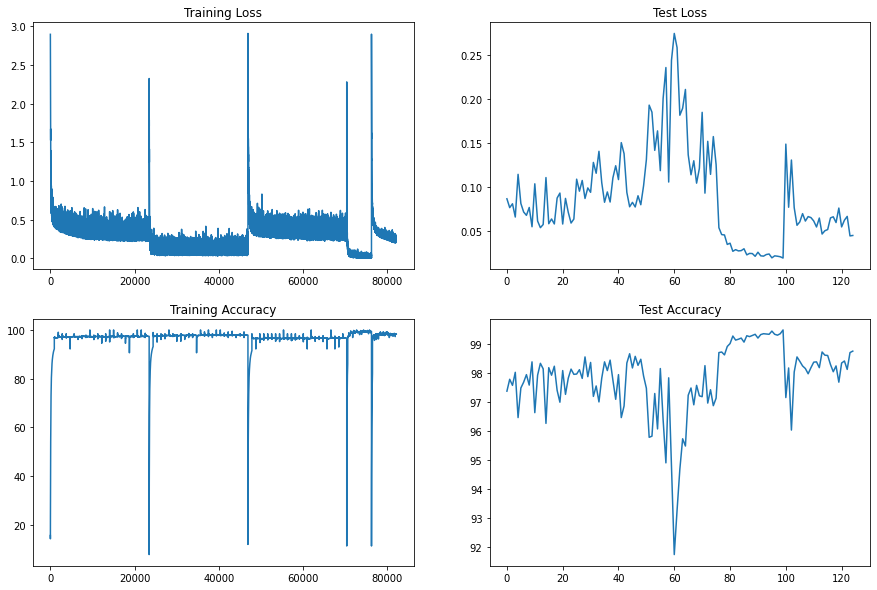

In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")
 